# Background field
Creation of a climatology using a background field create by `DIVAnd`. 

The key is in the definition of the _time selectors_:
1. for the background (using longer time periods) 
2. for the analysis.
Then in the final analysis, a `background` option allows user to specify the background file, the variable and the _time selector_.
```julia
...
background = DIVAnd.backgroundfile(filenamebackground,varname,TSbackground)
...
```

<div class="alert alert-block alert-warning">
⚠️ If you use a background field, don't use logarithmic transformations, which would let to error when applied to negative (anomaly) values.
</div>

In [1]:
using DIVAnd
using Makie, CairoMakie, GeoMakie
using NCDatasets
using PhysOcean
using DataStructures
using Dates
using Statistics
include("../config.jl")

[ Info: Precompiling PhysOcean [3725be50-bbbd-5592-92c3-2f0e82159c3e] (cache misses: wrong dep version loaded (4), incompatible header (4))


"https://dox.uliege.be/index.php/s/h8d3pyqmuea6J9H/download"

## Files and directories
For this application we will work on the Baltic Sea.

In [2]:
datafile = balticfile
varname = "salinity"

"salinity"

## Inputs
### Grid and depth levels

In [3]:
Δx = 0.25
Δy = 0.25
lonr = 9.5:Δx:29.25
latr = 53.0:Δy:67.0
timerange = [Date(1900,1,1),Date(2020,12,31)];
depthr = [0.,5., 10., 15., 20., 30.];

### Data
Download if needed.

In [4]:
download_check(balticfile, balticfileURL)

[ Info: File already downloaded


Read coordinates and observations

In [5]:
@time obsval,obslon, obslat, obsdepth, obstime,obsid = DIVAnd.loadobs(Float64, datafile, varname);

  5.270397 seconds (8.18 M allocations: 1.234 GiB, 10.00% gc time, 49.69% compilation time)


Check the observation ranges:

In [6]:
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

[ Info: Checking ranges for dimensions and observations


              minimum and maximum of obs. dimension 1: (8.972800254821777, 29.135000228881836)
              minimum and maximum of obs. dimension 2: (53.80670166015625, 65.80816650390625)
              minimum and maximum of obs. dimension 3: (0.0, 690.0)
              minimum and maximum of obs. dimension 4: (DateTime("1899-12-30T00:00:00"), DateTime("2013-11-07T09:16:00"))
                          minimum and maximum of data: (-0.09000000357627869, 36.47800064086914)


#### Quality check based on range

In [7]:
sel = (obsval .<= 40) .& (obsval .>= 0);
obsval = obsval[sel]
obslon = obslon[sel]
obslat = obslat[sel]
obsdepth = obsdepth[sel]
obstime = obstime[sel]
obsid = obsid[sel];

#### Plot unique observation locations

In [8]:
coords = [(x,y) for (x,y) in zip(obslon, obslat)];
coords_u = unique(coords);
@info "Total number of coordinates: $(length(coords))"
@info "Number of unique coordinates (profiles): $(length(coords_u))"
obslon_u = [x[1] for x in coords_u];
obslat_u = [x[2] for x in coords_u];

[ Info: Total number of coordinates: 11180368
[ Info: Number of unique coordinates (profiles): 170227


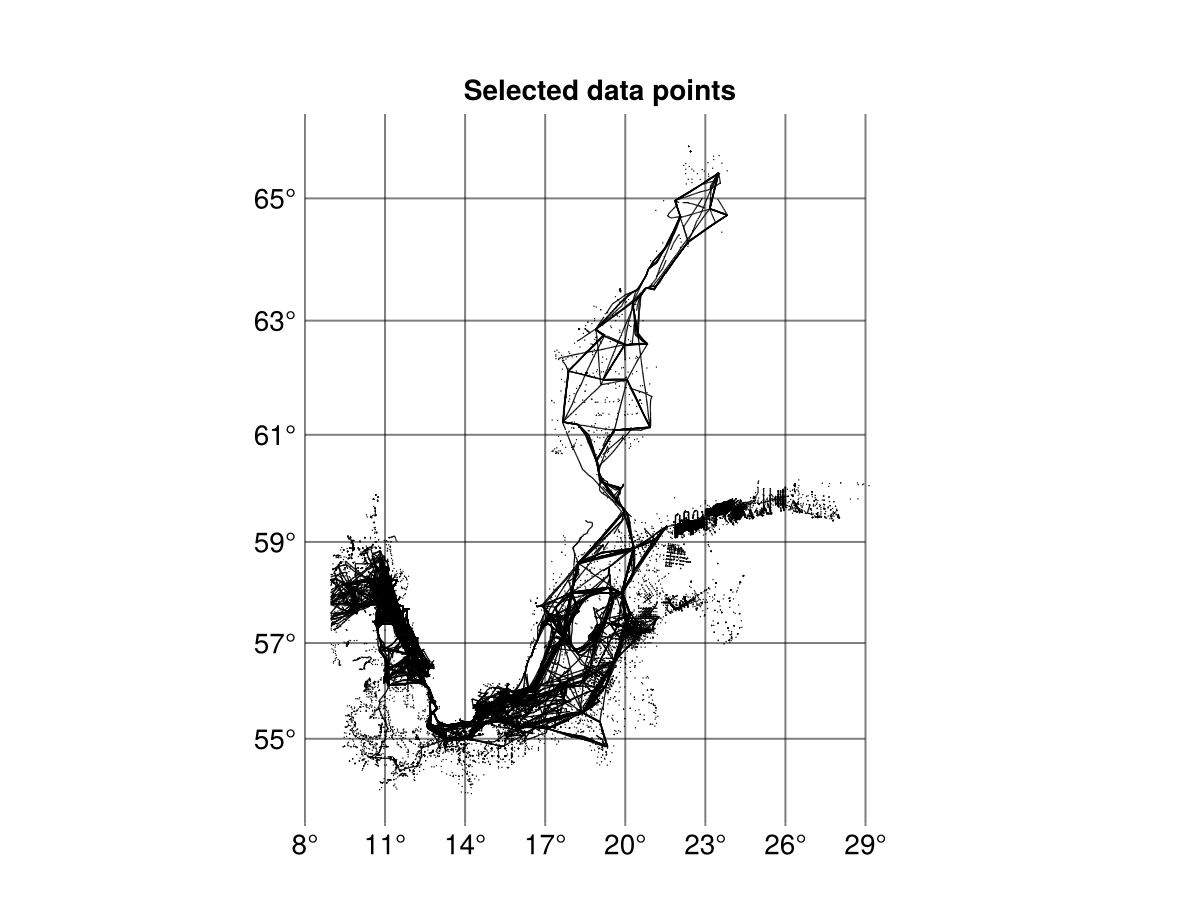

In [9]:
f = Figure()
ax = GeoAxis(f[1,1], dest = "+proj=merc", title="Selected data points", xticks=8.:3.:30., yticks=53.:2.:67.)
scatter!(ax, obslon_u, obslat_u, color="black", markersize=1)
f

### Bathymetry

In [10]:
bathname = gebco16file
download_check(gebco16file, gebco16fileURL)
bx, by, b = load_bath(bathname, true, lonr, latr);

[ Info: File already downloaded


#### Plotting

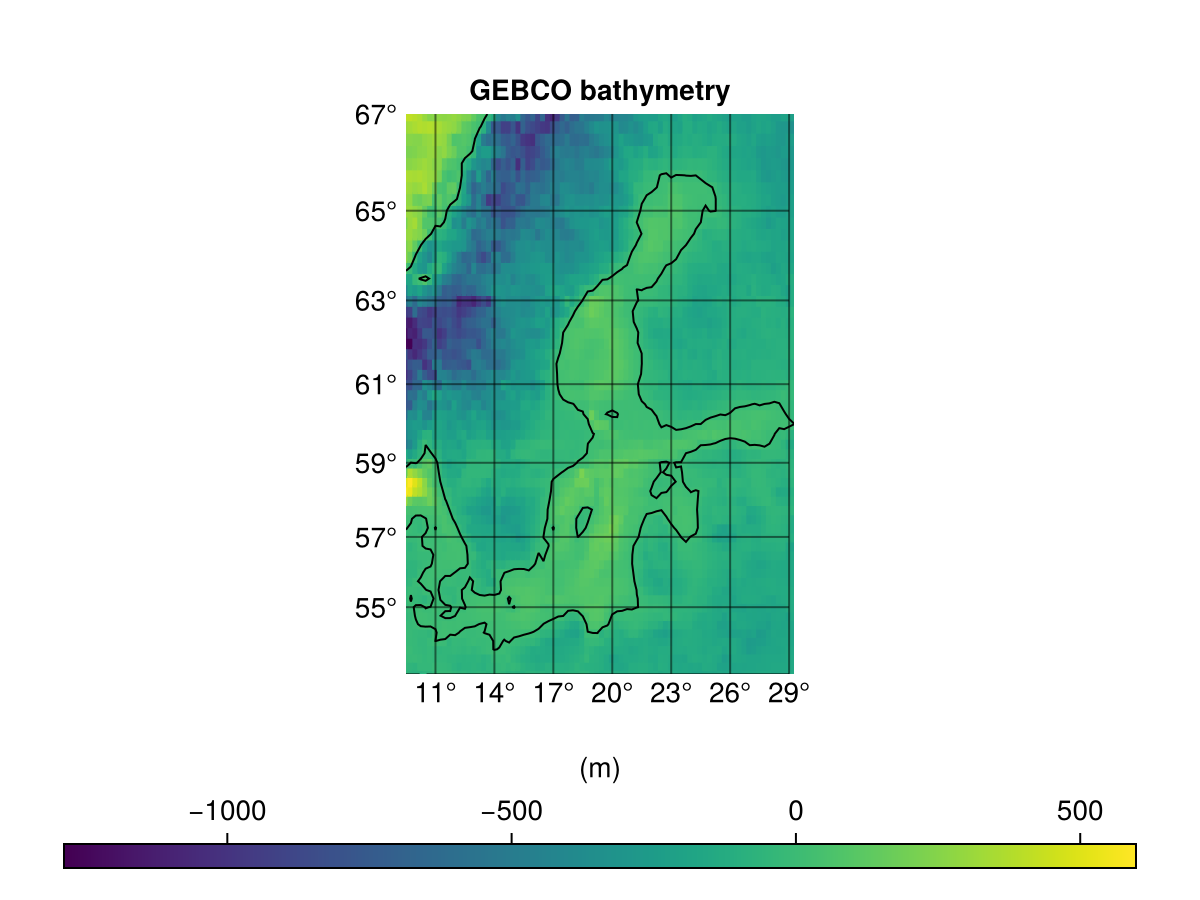

In [11]:
plot_bathy(bx, by, b, xticks=8.:3.:30., yticks=53.:2.:67.)

#### Land-sea mask

In [12]:
surfwater = b .>= depthr[1]
label = DIVAnd.floodfill(surfwater)
surfmask = label .== 1; # largest area has the label 1

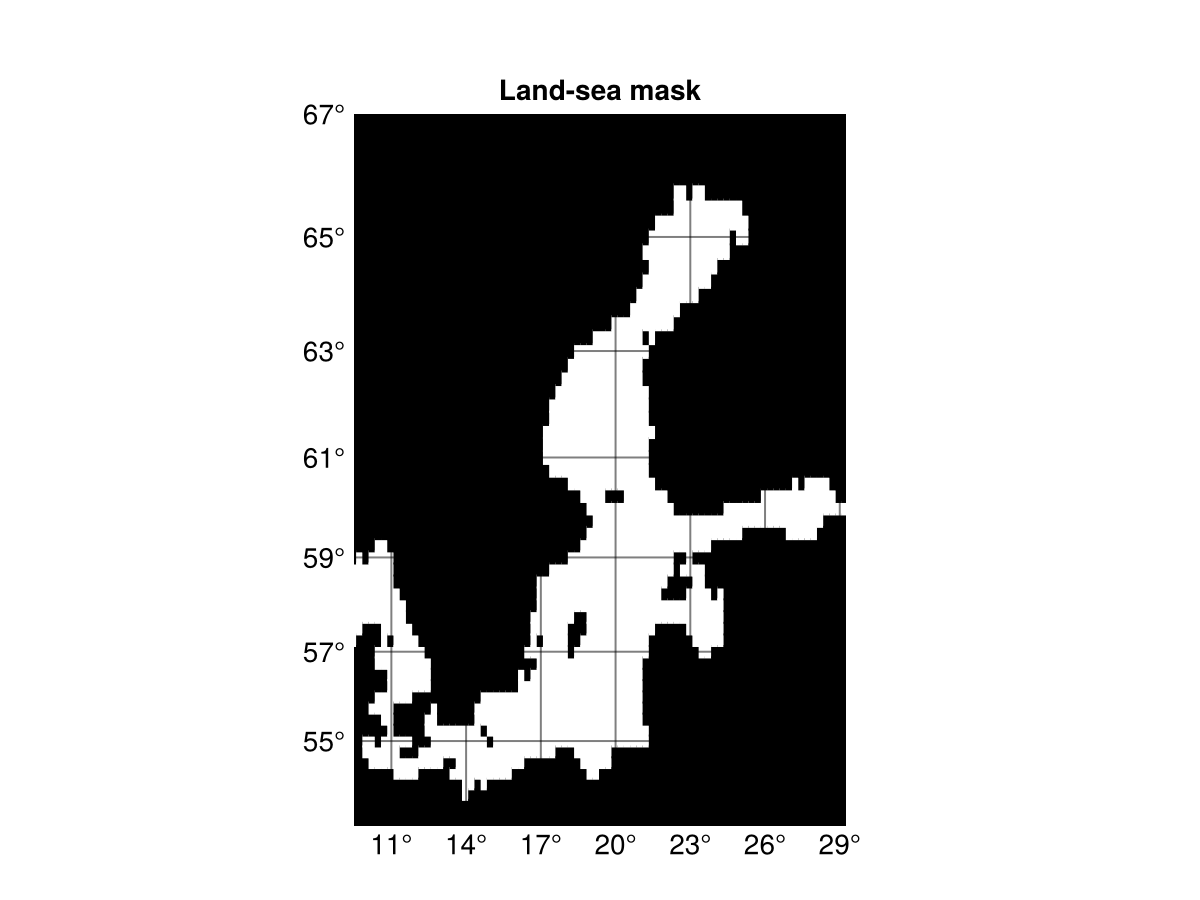

In [13]:
plot_mask(bx, by, surfmask, xticks=8.:3.:30., yticks=53.:2.:67.)

In [14]:
mask = falses(size(b,1),size(b,2),length(depthr))
for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = (b[i,j] >= depthr[k]) && surfmask[i,j]
        end
    end
end
@show size(mask)

size(mask) = (80, 57, 6)


(80, 57, 6)

## Analysis
### Background
For the background we create a _time selector_ with 4 seasons and 2 periods of years (1900-1989) and (1990-2017)

In [15]:
yearlist = [1900:1989,1990:2017];
monthlist = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]];  # Seasonal climatology
TSbackground = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);

#### Analysis parameters

In [16]:
sz = (length(lonr), length(latr), length(depthr));
lenx = fill(200_000.,sz)   # 200 km
leny = fill(200_000.,sz)   # 200 km
lenz = [min(max(30.,depthr[k]/150),300.) for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]]
len = (lenx, leny, lenz);
epsilon2 = 0.1;

solver = :direct

filenamebackground = joinpath(outputdir, "Water_body_$(replace(varname," "=>"_"))_Baltic_background.4Danl.nc")
filename = joinpath(outputdir, "Water_body_$(replace(varname," "=>"_"))_Baltic.4Danl.nc")

"../output/Water_body_salinity_Baltic.4Danl.nc"

#### Metadata for the netCDF file

Remove the background file if it already exists, and create the figure directory if needed.

In [17]:
if isfile(filenamebackground)
    rm(filenamebackground) # delete the previous analysis
    @info "Removing file $filenamebackground"
end

Let's define a plotting function that well be applied at each time and depth level.

In [18]:
function plotres(timeindex, sel, fit, erri)
    tmp = copy(fit)
    nx,ny,nz = size(tmp)
    for i in 1:nz
        f = Figure()
        ax = GeoAxis(f[1,1], title="Depth: $(depthr[i]) \n Time index: $(timeindex)")
        
        ylims!(ax, minimum(latr) - Δy, maximum(latr) + Δy)
        xlims!(ax, minimum(lonr) - Δx, maximum(lonr) + Δx)
        contourf!(ax, bx, by, surfmask, levels = 2, colormap=Reverse("binary"))
        cont = contourf!(ax, collect(lonr.-Δx/2.),collect(latr.-Δy/2.), tmp[:,:,i], levels=20, colormap=Reverse("RdYlBu"))

        cb = Colorbar(f[1, 2], cont)

        figname = varname * "_" * lpad(i, 2, '0') * "_" * lpad(timeindex, 3, '0') * ".png"
        save(joinpath(figdir, figname), f)
    end
end

plotres (generic function with 1 method)

#### Background analysis
We now have all the input to prepare the background field with `diva3d`.     
The analysis has 8 times steps: 4 seasons times 2 periods (1900-1989 and 1990-2017).

In [19]:
dbinfo = @time diva3d((lonr,latr,depthr,TSbackground),
           (obslon,obslat,obsdepth,obstime), obsval,
           len, epsilon2,
           filenamebackground,varname,
           bathname=bathname,
           mask = mask,
           fitcorrlen = false,
           niter_e = 2
       );

[ Info: Creating netCDF file ../output/Water_body_salinity_Baltic_background.4Danl.nc
[ Info: Time step 1 / 8
[ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (30.0, 30.0)
[ Info: number of windows: 1
[ Info: number of windows: 1
[ Info: Time step 2 / 8
[ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (30.0, 30.0)
[ Info: number of windows: 1
[ Info: number of windows: 1
[ Info: Time step 3 / 8
[ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (30.0, 30.0)
[ Info: number of win

 72.192650 seconds (111.93 M allocations: 43.465 GiB, 16.35% gc time, 54.82% compilation time)


### Final analysis
#### Parameters
We define the periods of interest for the final climatology.

In [20]:
yearlist = [1970:1979,1980:1989,1990:1999,2000:2009];
monthlist = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]];  # Seasonal climatology
TS = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);

We remove the final netCDF file if it exists.

In [21]:
if isfile(filename)
    rm(filename) # delete the previous analysis
    @info "Removing file $filename"
end

Now we can perform the analysis using background field, defined through the option      
`background = DIVAnd.backgroundfile(filenamebackground,varname,TSbackground)`:      
* `filenamebackground` is the name of the netCDF that you have created with the background
* `varname` is the name of the variable as written in the background netCDF and
* `TSbackground` is the *TimeSelector` object used to compute the background.

With these options set, the new analysis will select the correct background according to the considered period.     
We now have 16 time steps: 4 seasons times 4 year periods.

In [22]:
dbinfo = @time diva3d((lonr,latr,depthr,TS),
    (obslon,obslat,obsdepth,obstime), obsval,
    len, epsilon2,
    filename,varname,
    bathname=bathname,
    plotres = plotres,
    mask = mask,
    fitcorrlen = false,
    niter_e = 2,
    background = DIVAnd.backgroundfile(filenamebackground,varname,TSbackground)
);

[ Info: Creating netCDF file ../output/Water_body_salinity_Baltic.4Danl.nc
[ Info: Time step 1 / 16
[ Info: analysis time index 1 uses the background time index 1
[ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (30.0, 30.0)
[ Info: number of windows: 1
[ Info: number of windows: 1
[ Info: Time step 2 / 16
[ Info: analysis time index 2 uses the background time index 2
[ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (30.0, 30.0)
[ Info: number of windows: 1
[ Info: number of windows: 1
[ Info: Time step 3 / 16
[ Info: analysis time index 3 uses the background time index 3
[ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 2000

[ Info: scaled correlation length (min,max) in dimension 3: (30.0, 30.0)
[ Info: number of windows: 1
[ Info: number of windows: 1
[ Info: Time step 14 / 16
[ Info: analysis time index 14 uses the background time index 6
[ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (30.0, 30.0)
[ Info: number of windows: 1
[ Info: number of windows: 1
[ Info: Time step 15 / 16
[ Info: analysis time index 15 uses the background time index 7
[ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (30.0, 30.0)
[ Info: number of windows: 1
[ Info: number of windows: 1
[ Info: Time step 16 / 16
[ Info: analysis time index 16 uses the background time index 8
[ Info: scale

 96.545217 seconds (92.52 M allocations: 44.452 GiB, 16.20% gc time, 10.44% compilation time: 8% of which was recompilation)
